<a href="https://colab.research.google.com/github/AMiller113/Machine_Learning/blob/master/LSTM_Stock_Return_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow-gpu
import tensorflow as tf
tf.__version__

     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 3.8MB 49.8MB/s 
     |████████████████████████████████| 450kB 55.9MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.


'2.1.0'

In [0]:
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [0]:
# Pandas can take URLs as an argument
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [5]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [0]:
# Note: Incorrect method of trying to predict the price itself
series = df['close'].values.reshape(-1,1) # Takes the close column and reshapes to a N X 1 matrix for the standard scaler, .Values transforms the data frame to a numpy array

In [0]:
# Standardize the data as the values can vary widely
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten() # For the time series input and targets creation

In [8]:
# Setting up the data for time series prediction
T = 10 # Amount of values used to predict the next value
D = 1
X = [] # Holds the inputs
Y = [] # Holds the targets
for t in range((len(series))- T): # The length of N is equal to the total length of the data set minus the length of the time sequence
  x = series[t:t+T] # Holds a set of T values
  X.append(x) # Appends the set of T values to list X
  y = series[t+T] # Holds the target of the set of T values
  Y.append(y) # appends the target to list Y

X = np.array(X).reshape(-1, T, 1) # Makes list X an array and sets the size to (N X T x D) for the RNN
Y = np.array(Y) # Makes Y an array, no reshaping necessary as the lenth of Y is already equal to X
N = len(X) # Sets N to the length of array X
print('X.shape =', X.shape, ', Y.shape =',Y.shape)

X.shape = (1249, 10, 1) , Y.shape = (1249,)


In [9]:
# LSTM model
i = Input(shape=(T,1))
x = LSTM(5)(i)
x = Dense(1)(x)

model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.1))

r = model.fit(X[:-N//2], Y[:-N//2], epochs=80, validation_data=(X[-N//2:], Y[-N//2:]))

Train on 624 samples, validate on 625 samples
Epoch 1/80
624/624 [==============================] - 8s 12ms/sample - loss: 0.2287 - val_loss: 0.0556
Epoch 2/80
624/624 [==============================] - 0s 233us/sample - loss: 0.0163 - val_loss: 0.0210
Epoch 3/80
624/624 [==============================] - 0s 235us/sample - loss: 0.0070 - val_loss: 0.0196
Epoch 4/80
624/624 [==============================] - 0s 212us/sample - loss: 0.0059 - val_loss: 0.0367
Epoch 5/80
624/624 [==============================] - 0s 228us/sample - loss: 0.0060 - val_loss: 0.0214
Epoch 6/80
624/624 [==============================] - 0s 211us/sample - loss: 0.0078 - val_loss: 0.0171
Epoch 7/80
624/624 [==============================] - 0s 237us/sample - loss: 0.0062 - val_loss: 0.0278
Epoch 8/80
624/624 [==============================] - 0s 222us/sample - loss: 0.0062 - val_loss: 0.0196
Epoch 9/80
624/624 [==============================] - 0s 225us/sample - loss: 0.0057 - val_loss: 0.0205
Epoch 10/80
624/624

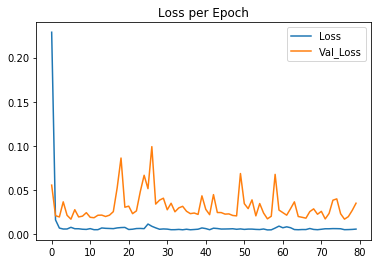

In [10]:
plt.plot(r.history['loss'], Label= 'Loss')
plt.plot(r.history['val_loss'], Label= 'Val_Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

(1249, 1)


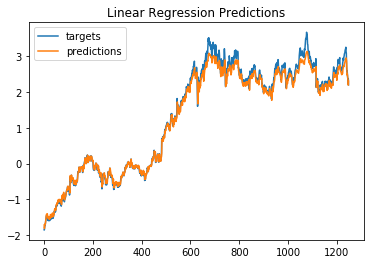

In [11]:
# One-Step forecast using true targets(LSTM)
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title('Linear Regression Predictions')
plt.legend()
plt.show()

In [0]:
# Forecast future values using only self predictions for making future predictions,(Not using the true targets)
validation_targets = Y[-N//2:]
validation_predictions = []

# Last Training input, begins where the validation set starts
last_x = X[-N//2]

while len(validation_predictions) < len(validation_targets):
  p = model.predict(last_x.reshape(1,T,1))[0,0] # Model.predct returns N=Samples by K=Output Nodes output in this case it returns a matrix [1,1] so the first position [0,0] must be indexed to get the value

# Update Predictions List
  validation_predictions.append(p)

# Make the New Input
  last_x = np.roll(last_x, -1) # np.roll shifts the array. Negative values shift to the left, positive values shift to the right
  last_x[-1] = p

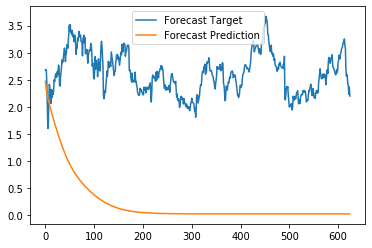

In [13]:
plt.plot(validation_targets, label ='Forecast Target')
plt.plot(validation_predictions, label='Forecast Prediction')
plt.legend()
plt.show()

In [0]:
# Calculate returns by shifting the data
df['PrevClose'] = df['close'].shift(1) # Move the column down by 1, making yesterdays closing price aligned with todays closing price

In [0]:
# Calculate Stock returns
df['return'] = (df['close'] - df['PrevClose'])/ df['PrevClose']

In [16]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


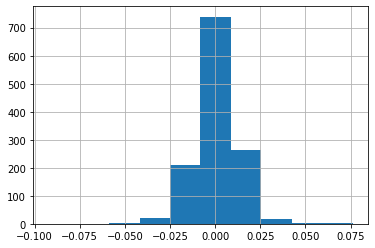

In [17]:
df['return'].hist()

In [0]:
# Takes the close column and reshapes to a N X 1 matrix for the standard scaler.
# Values transforms the data frame to a numpy array.
# [1:] slice ignores NaN first value in return

series = df['return'].values[1:].reshape(-1, 1) 

# Standardize the data
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten() # For the time series input and targets creation

In [19]:
# Setting up the data for time series prediction
T = 10 # Amount of values used to predict the next value
D = 1
X = [] # Holds the inputs
Y = [] # Holds the targets
for t in range((len(series))- T): # The length of N is equal to the total length of the data set minus the length of the time sequence
  x = series[t:t+T] # Holds a set of T values
  X.append(x) # Appends the set of T values to list X
  y = series[t+T] # Holds the target of the set of T values
  Y.append(y) # appends the target to list Y

X = np.array(X).reshape(-1, T, 1) # Makes list X an array and sets the size to (N X T x D) for the RNN
Y = np.array(Y) # Makes Y an array, no reshaping necessary as the lenth of Y is already equal to X
N = len(X) # Sets N to the length of array X
print('X.shape =', X.shape, ', Y.shape =',Y.shape)

X.shape = (1248, 10, 1) , Y.shape = (1248,)


In [20]:
# LSTM model
i = Input(shape=(T,1))
x = LSTM(5)(i)
x = Dense(1)(x)

model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.1))

r = model.fit(X[:-N//2], Y[:-N//2], epochs=80, validation_data=(X[-N//2:], Y[-N//2:]))

Train on 624 samples, validate on 624 samples
Epoch 1/80
624/624 [==============================] - 1s 2ms/sample - loss: 0.9994 - val_loss: 1.2744
Epoch 2/80
624/624 [==============================] - 0s 250us/sample - loss: 1.0116 - val_loss: 1.1556
Epoch 3/80
624/624 [==============================] - 0s 227us/sample - loss: 0.9961 - val_loss: 1.1443
Epoch 4/80
624/624 [==============================] - 0s 221us/sample - loss: 0.9862 - val_loss: 1.1529
Epoch 5/80
624/624 [==============================] - 0s 219us/sample - loss: 0.9894 - val_loss: 1.1789
Epoch 6/80
624/624 [==============================] - 0s 217us/sample - loss: 0.9826 - val_loss: 1.2161
Epoch 7/80
624/624 [==============================] - 0s 230us/sample - loss: 1.0034 - val_loss: 1.1986
Epoch 8/80
624/624 [==============================] - 0s 225us/sample - loss: 0.9888 - val_loss: 1.1511
Epoch 9/80
624/624 [==============================] - 0s 225us/sample - loss: 0.9958 - val_loss: 1.1525
Epoch 10/80
624/624 

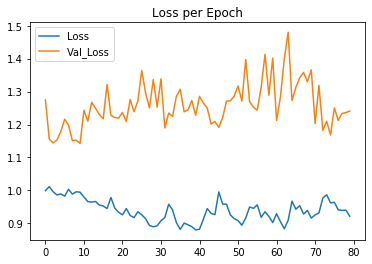

In [21]:
plt.plot(r.history['loss'], Label= 'Loss')
plt.plot(r.history['val_loss'], Label= 'Val_Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

(1248, 1)


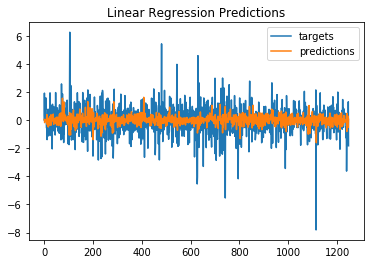

In [22]:
# One-Step forecast using true targets(LSTM)
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title('Linear Regression Predictions')
plt.legend()
plt.show()

In [0]:
# Forecast future values using only self predictions for making future predictions,(Not using the true targets)
validation_targets = Y[-N//2:]
validation_predictions = []

# Last Training input, begins where the validation set starts
last_x = X[-N//2] # The index will contain a time series of length T

while len(validation_predictions) < len(validation_targets):
  p = model.predict(last_x.reshape(1,T,1))[0,0] # Model.predct returns N=Samples by K=Output Nodes output in this case it returns a matrix [1,1] so the first position [0,0] must be indexed to get the value

# Update Predictions List
  validation_predictions.append(p)

# Make the New Input
  last_x = np.roll(last_x, -1) # np.roll shifts the array. Negative values shift to the left, positive values shift to the right
  last_x[-1] = p

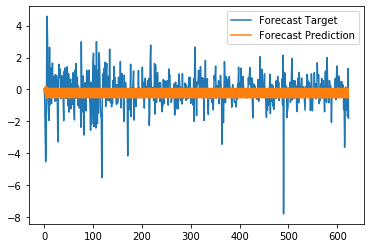

In [24]:
plt.plot(validation_targets, label ='Forecast Target')
plt.plot(validation_predictions, label='Forecast Prediction')
plt.legend()
plt.show()

In [0]:
# Turn full data into numpy arrays
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['return'].values

In [0]:
T = 10 # The amount of data points to be used for each prediction
D = input_data.shape[1] # The amount of features in the input data
N = len(input_data) - T # This excludes the initial data points needed to make the first prediciton (so the sample size must be T less the all the data points)

In [0]:
# Normalize the inputs
N_train = len(input_data) * 2 // 3 # Makes the first 2/3rds of the data the training set
scaler = StandardScaler()
scaler.fit(input_data[:N_train+T])
input_data = scaler.transform(input_data)

In [0]:
# Setup X_train and Y_train
X_train = np.zeros((N_train, T, D))
Y_train = np.zeros(N_train)

for t in range(N_train):
  X_train[t, :, :] = input_data[t:t+T] # Gets the T x D data at entry t of the input data
  Y_train[t] = (targets[t+T] > 0) # Whether or not the return went up or down

In [0]:
# Setup X_test and Y_test
X_test = np.zeros((N - N_train, T, D))
Y_test = np.zeros(N - N_train)

for u in range(N_train - N):
  t = N_train + u # Goes through the indexes of the validation set of the input data and targets
  X_test[u, :, :] = input_data[t:t+T] # Gets the T x D data at entry t of the input data
  Y_test[u] = (targets[t+T] > 0) # Whether or not the return went up or down

In [0]:
# Make the new LSTM for binary classifaction
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i,x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [31]:
# Train model
r = model.fit(X_train, Y_train, epochs = 300, batch_size=32,validation_data=(X_test, Y_test))

Train on 839 samples, validate on 410 samples
Epoch 1/300
839/839 [==============================] - 2s 2ms/sample - loss: 0.6952 - accuracy: 0.5125 - val_loss: 0.7059 - val_accuracy: 0.0000e+00
Epoch 2/300
839/839 [==============================] - 0s 203us/sample - loss: 0.6938 - accuracy: 0.5232 - val_loss: 0.7182 - val_accuracy: 0.0000e+00
Epoch 3/300
839/839 [==============================] - 0s 207us/sample - loss: 0.6909 - accuracy: 0.5268 - val_loss: 0.7235 - val_accuracy: 0.0000e+00
Epoch 4/300
839/839 [==============================] - 0s 210us/sample - loss: 0.6906 - accuracy: 0.5221 - val_loss: 0.7343 - val_accuracy: 0.0000e+00
Epoch 5/300
839/839 [==============================] - 0s 224us/sample - loss: 0.6884 - accuracy: 0.5340 - val_loss: 0.7293 - val_accuracy: 0.0000e+00
Epoch 6/300
839/839 [==============================] - 0s 208us/sample - loss: 0.6890 - accuracy: 0.5352 - val_loss: 0.7385 - val_accuracy: 0.0000e+00
Epoch 7/300
839/839 [=============================

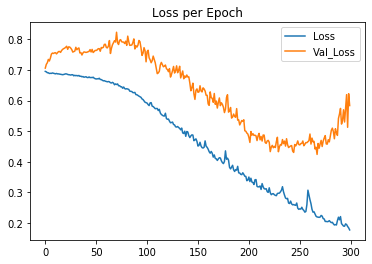

In [32]:
plt.plot(r.history['loss'], Label= 'Loss')
plt.plot(r.history['val_loss'], Label= 'Val_Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

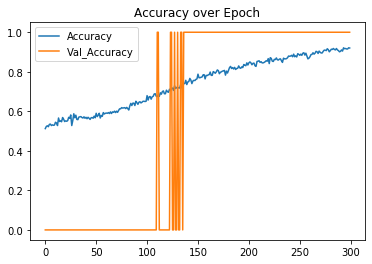

In [33]:
plt.plot(r.history['accuracy'], Label = 'Accuracy')
plt.plot(r.history['val_accuracy'], Label = 'Val_Accuracy')
plt.legend()
plt.title('Accuracy over Epoch')
plt.show()